In [1]:
dataset='rna'
grid_search_results_dir='grid_search_results'
vmins = {'adult' : 0.3055, 'phishing' : 0.070, 'ijcnn' : 0.04, 'rna' : 0.124}
vmaxs = {'adult' : 0.3085, 'phishing' : 0.105, 'ijcnn' : 0.12, 'rna' : 0.138}

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import seaborn as sns

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def plot_IO_embeddings(dataset, grid_search_results_dir, what):
    solvers = [
        'fm1p25_w_linear' + what,
        'fm1p5_w_linear' + what,
        'fm1p75_w_linear' + what,
        'fm2p0_w_linear' + what,
        'fm2p25_w_linear' + what,
        'fm2p5_w_linear' + what,
        'fm2p75_w_linear' + what,
        'fm3p0_w_linear' + what,
        #'fmho3_w_linear' + what,
        #'fmho2and3_w_linear' + what
    ]
    dfs = []
    for solver in solvers:
        df = pd.read_csv('./moredata/{dataset}/{grid_search_results_dir}/{solver}.pred'.format(dataset=dataset, grid_search_results_dir=grid_search_results_dir, solver=solver), names=[solver])
        df.colnames = [solver]
        df[solver] = np.log(df[solver] / (1.0 - df[solver]))
        dfs.append(df)
    df = pd.concat(dfs, axis=1)
    corrmat = df.corr()
    #_, ax = plt.subplots(figsize=(12,9))
    #sns.heatmap(corrmat, square=True, annot=True, fmt='.3f', annot_kws={'size': 10})
    from numpy.linalg import svd
    u, s, vh = np.linalg.svd(corrmat, full_matrices=True)
    k = 2
    #np.matmul(u[:, :k], np.matmul(np.diag(s[:k]), vh[:k, :]))
    embeddings = u[:, :k]
    # De aca: https://stackoverflow.com/questions/5147112/how-to-put-individual-tags-for-a-scatter-plot
    plt.subplots_adjust(bottom = 0.1)
    plt.figure(figsize=(20,10))
    plt.scatter(
        embeddings[:, 0], embeddings[:, 1], marker='o',
        cmap=plt.get_cmap('Spectral'))
    plt.title(dataset + ' ' + what)

    for label, x, y in zip(df.columns, embeddings[:, 0], embeddings[:, 1]):
        text_y_offset = 0
        text_x_offset = -50
        plt.annotate(
            label,
            xy=(x, y), xytext=(text_x_offset, text_y_offset),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    plt.show()
    

In [4]:
for what in ['', 
             '_neutral', 
             '_reversed', 
             #'_no_diag', 
             #'_neutral_no_diag', 
             #'_reversed_no_diag'
            ]:
    plot_IO_embeddings(dataset=dataset, 
                       grid_search_results_dir=grid_search_results_dir, 
                       what=what
                      )

FileNotFoundError: File b'./moredata/rna/grid_search_results/fm1p25_w_linear.pred' does not exist

In [6]:
def plot_io_and_symmetry(dataset, grid_search_results_dir, what):
    '''
    :param what: '' or 'no_diag'
    '''
    assert what in ['', '_no_diag']
    vmin = vmins[dataset]
    vmax = vmaxs[dataset]
    def get_loss(dataset, grid_search_results_dir, solver):
        import os
        loss_file_path = 'moredata/{dataset}/{grid_search_results_dir}/{solver}.loss'.format(dataset=dataset, grid_search_results_dir=grid_search_results_dir, solver=solver)
        if not os.path.isfile(loss_file_path):
            print("file %s not found" %loss_file_path)
        assert os.path.isfile(loss_file_path)
        res = 0.0
        for line in open(loss_file_path):
            res = float(line)
        return res
    symmetries = [
        '',
        '_neutral',
        'ensemble',
        '_reversed'
    ]
    symmetry_names = [
        'FM-Standard',
        'FM-Neutral',
        'FM-Standard + FM-Reversed',
        'FM-Reversed'
    ]
    symmetry_idx = [0, 1, 3]
    ensemble_idx = 2
    rows_to_show = [0, 1, 2, 3]
    print("showing rows %s"%str(rows_to_show))
    assert(ensemble_idx not in symmetry_idx)
    orders = [
        'fm1p25',
        'fm1p5',
        'fm1p75',
        'fm2p0',
        'fm2p25',
        'fm2p5',
        'fm2p75',
        'fm3p0',
        #'fmho3',
        #'fmho2and3'
    ]
    order_names = [
        '1.25',
        '1.5',
        '1.75',
        '2.0',
        '2.25',
        '2.5',
        '2.75',
        '3.0',
        #'exact 3',
        #'exact 2 and 3'
    ]
    num_symmetries = len(symmetries)
    num_orders = len(orders)
    loss = np.zeros((num_symmetries, num_orders))
    for i in symmetry_idx:
        symmetry = symmetries[i]
        for j, order in enumerate(orders):
            solver = '{order}_w_linear{symmetry}{what}'.format(order=order, symmetry=symmetry, what=what)
            loss[i][j] = get_loss(dataset, grid_search_results_dir, solver=solver)
            loss[ensemble_idx][j] = get_loss(dataset, grid_search_results_dir, solver='{order}_w_linear{what}_AND_{order}_w_linear_reversed{what}'.format(order=order, what=what))
    plt.figure(figsize=(12, 4))
    ax = sns.heatmap(loss[rows_to_show], 
                     linewidth=0.5, 
                     vmin=vmin, 
                     vmax=vmax,
                     annot=True,
                     fmt='.5f',
                     square=True,
                     xticklabels=order_names,
                     yticklabels=np.array(symmetry_names)[rows_to_show],
                     cmap = 'Greys')
    plt.yticks(rotation=0)
    plt.xlabel('interaction order')
    plt.ylabel('symmetry type')
    if 'early_stop_test' in grid_search_results_dir:
        plt.title(dataset + ' biased grid search')
        plt.savefig('moredata/{dataset}/IO_early_stop_test{what}'.format(dataset=dataset,what=what))
    else:
        plt.title(dataset + ' grid search')
        plt.savefig('moredata/{dataset}/IO{what}'.format(dataset=dataset,what=what))
    plt.show()

showing rows [0, 1, 2, 3]


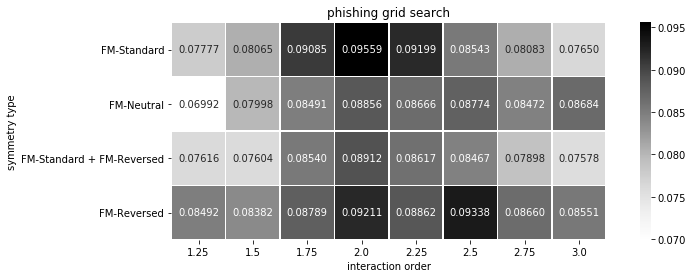

In [6]:
vmins = {'phishing' : 0.06992}
vmaxs = {'phishing' : 0.09559}
plot_io_and_symmetry(dataset='phishing', #OK
                     grid_search_results_dir=grid_search_results_dir, 
                     what='')

In [7]:
#vmins = {'phishing' : 0.06418}
#vmaxs = {'phishing' : 0.09559}
#plot_io_and_symmetry(dataset='phishing', #OK
#                     grid_search_results_dir='grid_search_results_early_stop_test', 
#                     what='')

showing rows [0, 1, 2, 3]


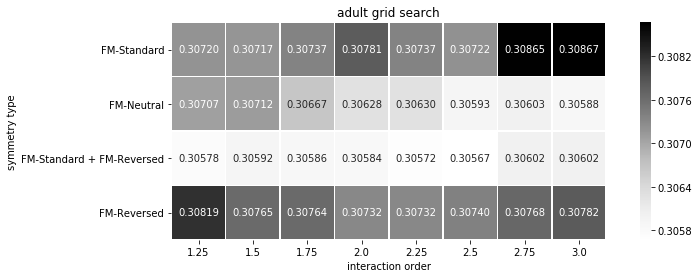

In [8]:
vmins = {'adult' : 0.30567}
vmaxs = {'adult' : 0.30867}
plot_io_and_symmetry(dataset='adult', # OK
                     grid_search_results_dir=grid_search_results_dir, 
                     what='')

In [9]:
#vmins = {'adult' : 0.30529}
#vmaxs = {'adult' : 0.30867}
#plot_io_and_symmetry(dataset='adult', # OK
#                     grid_search_results_dir='grid_search_results_early_stop_test', 
#                     what='')

In [10]:
vmins = {'ijcnn' : 0.04346}
vmaxs = {'ijcnn' : 0.08344}
plot_io_and_symmetry(dataset='ijcnn', # OK
                     grid_search_results_dir=grid_search_results_dir, 
                     what='')

showing rows [0, 1, 2, 3]


In [11]:
#vmins = {'ijcnn' : 0.03482}
#vmaxs = {'ijcnn' : 0.08344}
#plot_io_and_symmetry(dataset='ijcnn', # OK
#                     grid_search_results_dir='grid_search_results_early_stop_test', 
#                     what='')

In [12]:
vmins = {'rna' : 0.12238}
vmaxs = {'rna' : 0.13015}
plot_io_and_symmetry(dataset='rna',
                     grid_search_results_dir=grid_search_results_dir, 
                     what='')

showing rows [0, 1, 2, 3]


In [13]:
#vmins = {'rna' : 0.122}
#vmaxs = {'rna' : 0.136}
#plot_io_and_symmetry(dataset='rna',
#                     grid_search_results_dir='grid_search_results_early_stop_test', 
#                     what='')

showing rows [0, 1, 2, 3]


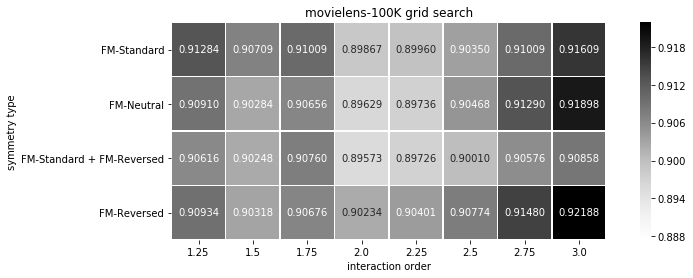

In [15]:
vmins = {'movielens-100K' : 0.88745}
vmaxs = {'movielens-100K' : 0.92188}
plot_io_and_symmetry(dataset='movielens-100K',
                     grid_search_results_dir=grid_search_results_dir, 
                     what='')

showing rows [0, 1, 2, 3]


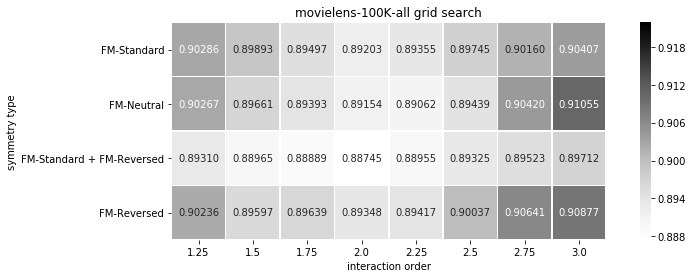

In [17]:
vmins = {'movielens-100K-all' : 0.88745}
vmaxs = {'movielens-100K-all' : 0.92188}
plot_io_and_symmetry(dataset='movielens-100K-all',
                     grid_search_results_dir=grid_search_results_dir, 
                     what='')

showing rows [0, 1, 2, 3]


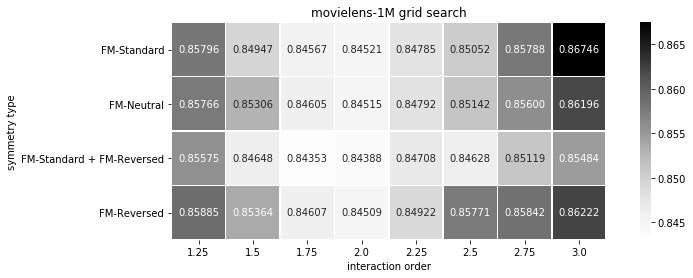

In [25]:
vmins = {'movielens-1M' : 0.84305}
vmaxs = {'movielens-1M' : 0.86746}
plot_io_and_symmetry(dataset='movielens-1M',
                     grid_search_results_dir=grid_search_results_dir, 
                     what='')

showing rows [0, 1, 2, 3]


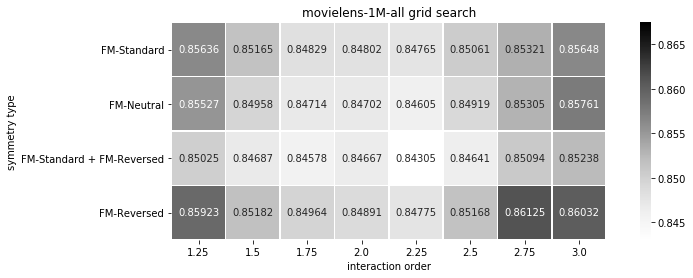

In [26]:
vmins = {'movielens-1M-all' : 0.84305}
vmaxs = {'movielens-1M-all' : 0.86746}
plot_io_and_symmetry(dataset='movielens-1M-all',
                     grid_search_results_dir=grid_search_results_dir, 
                     what='')